In [1]:
!pip install scikit-commpy

     |████████████████████████████████| 51kB 4.1MB/s 


In [2]:
import random
import numpy as np
import commpy
import matplotlib.pyplot as plt
import math
import os
from os import path


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Data Segmentation

In [4]:
#@title Generation Parameters
num_keys =  10#@param {type:"integer"}
# num_of_chunks is exceeta
num_of_chunks=32#@param {type:"integer"}

ifft_length=64

Modulation Properties

In [5]:
#@title For every 10 samples that are generated for training, 2 are generated for testing and validation { display-mode: "both" }
train_samples = 250 #@param {type:"slider", min:10, max:1000, step:10}
test_samples = int(0.2*train_samples)
snr_db =  10#@param {type:"integer"}
alpha =   0.2#@param {type:"number"}




ma = 2#@param {type:"integer"} # bits per symbol/sub-carrier
m=ma; # loop modulation order
Ma = 2**(ma); # modulation order
modem = commpy.modulation.QAMModem(Ma) #QAM modulator
num_of_frames=train_samples+test_samples


**Set target directory (based on above parameters)**

In [6]:
import pathlib
file_path = '/content/gdrive/My Drive/Colab Notebooks/SASM/Datasets'
os.makedirs(file_path,exist_ok=True) # create folders necessary to store data
data_dir = pathlib.Path(file_path)

Create codewords

In [7]:
def cal_power(signal):
  dummy5=np.asarray(np.transpose(signal))
  dummy6=dummy5.ravel()
  result=np.zeros(len(dummy6))
  for i in range(len(dummy6)):
           result[i]= dummy6[i] * dummy6[i]
  calculated_power=sum(result)/len(result)
  calculated_power_db=10*np.log10(calculated_power)
  return calculated_power_db

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


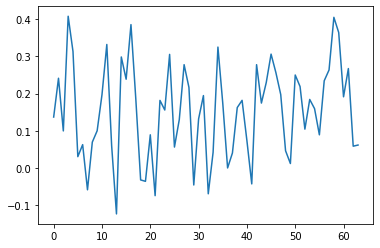

In [8]:
# min_snr = 0
# max_snr = 1
# step = 1
tx_symifftfinal=[]
copy_tx_symifftfinal=[]
# The reason for the "for xxx in [xxx]" pieces of code is that for the generation of signals from multiple ranges or numbers of transmitters or snrs, the [xxx] can be replaces with [x1, x2, ..., xn]
#for alpha in [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]:
for alpha in [alpha]:
    dBm=20 # signal power dBm
    jj=dBm
    spow=10**(dBm/10)*1e-3 # signal power mW
    for num_keys in [num_keys]:
        codeword=np.zeros((num_keys,ifft_length))
        np.random.seed(1) # The chosen fixed seed!
        for i in range(0,num_keys):
            A=np.random.randint(2, size=(1, num_of_chunks)) 
            C=np.repeat(A,ifft_length/num_of_chunks)
            codeword[i]=2*C-1 
        for snr_db in [snr_db]:
            ztx=np.zeros((ifft_length,num_of_frames))
            # fig=plt.figure()
            x_train = np.empty([train_samples*num_keys,ifft_length,1])
            x_test = np.empty([test_samples*num_keys,ifft_length,1])
            y_train = np.empty([train_samples*num_keys,])
            y_test = np.empty([test_samples*num_keys,])
            for frames in range(0,num_of_frames):
                for j in range(0,num_keys):
                    bit_streama=np.random.randint(2,size=(int(ifft_length/4),ma)) # generate bits
                    message_symbols=np.empty([len(bit_streama),1],dtype=complex)
                    
                    for ii in range(0,len(bit_streama)):  
                        draft=bit_streama[ii]
                        message_symbols[ii]=modem.modulate(draft.tolist())
                    tx_symaa=message_symbols
                    symba=np.zeros([int(ifft_length/2),1],dtype=complex)
                    loop=0;
                    # Generate ACO-OFDM with zero padding of the first half of the IFFT bins
                    for uu in range(0,len(symba),2):
                        symba[uu] = tx_symaa[loop];
                        loop = loop+1;
                    z=np.array([[0]],dtype=complex)
                    tx_syma=np.concatenate((z,symba[0:int(ifft_length/2)-1],z,np.flip(np.conj(symba[0:int(ifft_length/2)-1]))))
                    tx_symiffta=np.fft.ifft(tx_syma,axis=0)
                    
                    tx_symiffta[tx_symiffta<0]=0; # convert to unipolar positive
                
                    x_axis=range(ifft_length)

                    tx_symifftfinal = np.empty_like(tx_symiffta)
                    tx_symifftfinal[:,] = tx_symiffta[:,]

                    calculated_power=cal_power(tx_symifftfinal)     

                    
                    dummy=codeword[j,:]
                    tx_symifftfinal[dummy==1]=tx_symifftfinal[dummy==1]+alpha;
                    tx_symifftfinal[dummy==-1]=tx_symifftfinal[dummy==-1];
                    dummy2=np.real(tx_symifftfinal)

                    calculated_power2=cal_power(dummy2)  


                    # Adding awgn
                    noise_db = calculated_power2 - snr_db
                    noise_watts = 10 ** (noise_db / 10)

                    dummy3=np.transpose(dummy2)
                    dummy3=np.real(dummy3)+np.random.normal(0, np.sqrt(noise_watts), 64)
                    dummy3=np.transpose(dummy3)

                    if frames < train_samples:
                      x_train[num_keys*frames+j] = dummy3
                      y_train[num_keys*frames+j] = j
                    else:
                      x_test[num_keys*(frames-train_samples)+j] = dummy3
                      y_test[num_keys*(frames-train_samples)+j] = j


            plt.plot(dummy3)
            # plt.title(str(frames))
            # plt.show()  
            file_name = file_path + '/keys_' + str(num_keys) + '_snr_' + str(snr_db) + '_range_' + str(alpha) + '_exceeta_' + str(num_of_chunks) + '_ifft_' + str(ifft_length) + '_samples_' + str(train_samples) + '.npz'
            np.savez_compressed(file_name, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)
            file_name

To plot the signals

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


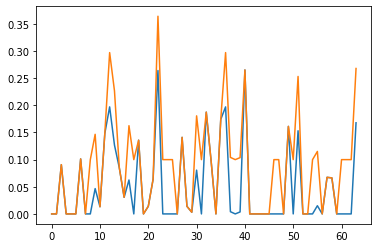

In [ ]:
plt.plot(tx_symiffta)
plt.plot(tx_symifftfinal)
#copy_tx_symifftfinal=[]
#copy_tx_symifftfinal=tx_symifftfinal;
#copy_tx_symifftfinal[dummy==1]=copy_tx_symifftfinal[dummy==1]+alpha;
#copy_tx_symifftfinal[dummy==-1]=copy_tx_symifftfinal[dummy==-1];
#plt.plot(copy_tx_symifftfinal)
#print(tx_symiffta)
#print(tx_symifftfinal)
#print(copy_tx_symifftfinal)
np.savetxt(file_path + "/num_of_chunks_" + str(num_of_chunks) + "_original.csv", np.real(tx_symiffta), delimiter=',')
np.savetxt(file_path + "/num_of_chunks_" + str(num_of_chunks) + "_pointone.csv", np.real(tx_symifftfinal),delimiter=',')
#np.savetxt(file_path + "/num_of_chunks_" + str(num_of_chunks) + "_pointtwo.csv", np.real(copy_tx_symifftfinal),delimiter=',')